In [1]:
%matplotlib inline
import os
from glob import glob
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Dense, concatenate

from tensorflow.keras.layers import Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix
from plot_confusion_matrix import plot_confusion_matrix

import cv2
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
def read_data(directory):
# =============================================================================
#  This function gets a directory name and returns all images in it concatenated 
#  to each other
# =============================================================================    
    data_list = glob(os.path.join(directory ,r'*.png'))
    #print(os.path.join(directory,'*.png'))
    data = np.asarray([cv2.imread(img,0) for img in data_list])
    return data


In [3]:
# display COCO categories and supercategories
# cats = coco.loadCats(coco.getCatIds())
# nms=[cat['name'] for cat in cats]
# print('COCO categories: \n{}\n'.format(' '.join(nms)))

# nms = set([cat['supercategory'] for cat in cats])
# print('COCO supercategories: \n{}'.format(' '.join(nms)))

In [4]:
# the index of the image from the set just to visualize 
img_idx = 0

dataDir = "E:\Documents\Study\Deep Learning\Project\DATA"
train_data_name = "train2017"
val_data_name = "val2017"

# we resize the images because of memory limitations on my 32GB RAM and 4GB GPU memory
img_width = 64
img_height = 64

# size of the data set for debug {None => all the data} 
max_cnt_debug_train = None
max_cnt_debug_test = 10

# load images in grayscale or in RGB when rgb_on = 1 it will load rgb images
rgb_on = 1

# parameters for the training model number of classes will be autometicly generated based on the number of categories
lr =          1e-4        # learning rate 
beta_1 =      0.9         # beta 1 - for adam optimizer
beta_2 =      0.95        # beta 2 - for adam optimizer
epsilon =     1e-7        # epsilon - for adam optimizer
epochs =      100          # number of epochs
bs =          64          # batch size
dp =          0.5         # dropout probability


# in the .getCatIds(catNms=[list of all ids we want to filter from the data]);
categories_names = ['person']


loading annotations into memory...
Done (t=12.20s)
creating index...
index created!


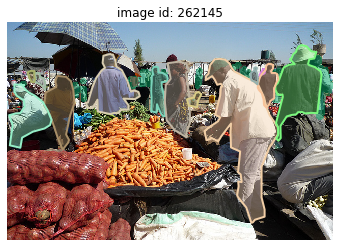

In [5]:
# load captions
#coco_caps= COCO(os.path.join(dataDir,r"annotations\captions_" + data_name + ".json"))

# Load insatnces -> here we take the masks
coco_instances = COCO(os.path.join(dataDir,r"annotations\instances_" + train_data_name + ".json"))

# Load key points
#coco_key_p = COCO(os.path.join(dataDir,r"annotations\person_keypoints_" + data_name + ".json")) 

# get the id for each category specified
catIds = coco_instances.getCatIds(catNms=categories_names);

#get all image id in the directory
all_imgIds = coco_instances.getImgIds()

# get all the image id for all images based on the filter
imgIds = coco_instances.getImgIds(catIds=catIds);

# get the data for each image id with specified annotations
img_data = coco_instances.loadImgs(imgIds)

# Visualize the img_idx specified up here
I = io.imread(os.path.join(dataDir, train_data_name +r"//" +str(imgIds[img_idx]).zfill(12) + ".jpg"))
plt.imshow(I); 
plt.axis('off')
plt.title("image id: " + str(imgIds[img_idx]))

# and show the mask on top of the image
annIds = coco_instances.getAnnIds(imgIds=imgIds[img_idx], catIds=catIds, iscrowd=None)
anns = coco_instances.loadAnns(annIds)
coco_instances.showAnns(anns)

#plot key points
#annIds_keys = coco_key_p.getAnnIds(imgIds=imgIds[idx], catIds=catIds, iscrowd=None)
#anns_keys = coco_key_p.loadAnns(annIds_keys)
#coco_key_p.showAnns(anns_keys)

#print the caption
#annIds = coco_caps.getAnnIds(imgIds=imgIds[idx]);
#anns = coco_caps.loadAnns(annIds)
#coco_caps.showAnns(anns)

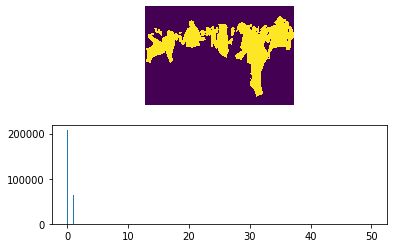

In [6]:
#visualize the mask of the annotaion
# every annotation has a id (number) for every pixel on the mask we multiply by id
# pixel = id = we have annotation in the pixel
# pixel = 0 we dont have annotation in that spot
anns_img = np.zeros((img_data[img_idx]['height'],img_data[img_idx]['width']))
for ann in anns:
    #mask += coco_instances.annToMask(anns[i])*anns[i]['category_id'] 
    anns_img = np.maximum(anns_img, coco_instances.annToMask(ann)*ann['category_id'])
    
plt.subplot(2,1,1)    
plt.imshow(anns_img)
plt.axis('off')
plt.subplot(2,1,2)
# Visuaslize the histogram of the mask
plt.hist(anns_img.ravel(),256, [0,50]);

In [7]:
mask_list = [] # init empty list for masks

# we load all the images in grayscale because of memory limitations
img_list = [] # init empty list to store all the image data

for cnt, imgID in enumerate(all_imgIds):
    I = cv2.imread(os.path.join(dataDir, train_data_name +r"//" +str(imgID).zfill(12) + ".jpg"), rgb_on)
    I = cv2.resize(I, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)
    img_list.append(I)
    
    if (imgID in imgIds):
        # get all annotation ids for img id
        annIds = coco_instances.getAnnIds(imgIds=imgID, catIds=catIds, iscrowd=None) 
        # load all annotation inside the image
        anns = coco_instances.loadAnns(annIds) 
        # image data for image specification width height etc..
        #img_data = coco_instances.loadImgs(imgID)[0] 
    
        # init empty mask
        anns_img = np.zeros((img_height, img_width),) 
        for ann in anns:
            # resize the mask of the  specific anotation in the image
            mask_res = cv2.resize(coco_instances.annToMask(ann), (img_height, img_width), interpolation = cv2.INTER_AREA )
            # add the mask multiplid by the category index for category 
            # here we multiply by the index of the annotation +1
            # for easier way to_categories
            # if we have only one category it will be mask of only zeros ans ones
            # if we would multiply by the category id the to_category will make more categories then we need
            # for example if the category is 17 it will generate 18 categories and we need only 2
            anns_img = np.maximum(anns_img, mask_res*(catIds.index(ann['category_id'])+1))
    else:
        anns_img = np.zeros((img_height, img_width),)
    # for debug save the mask to the disk
    #cv2.imwrite(r"E:\Documents\Study\Deep Learning\Project\MASKS\\" +str(imgID).zfill(12) + ".png" , anns_img)
    mask_list.append(anns_img)
    
    if (cnt+1 == max_cnt_debug_train):
        break

# read the masks from the disk
#y_train = read_data(r'E:\Documents\Study\Deep Learning\Project\MASKS')
#y_train = (to_categorical(y_train)).astype('float')

y_train = np.asarray(mask_list)
y_train = (to_categorical(y_train, num_classes=None, dtype='float32')).astype('float')

x_train = np.asarray(img_list)
if (rgb_on == 0):
    x_train = (np.expand_dims(x_train, axis=3)).astype('float')

print('y_train shape:', y_train.shape)
print('x_train shape:', x_train.shape)

y_train shape: (118287, 64, 64, 2)
x_train shape: (118287, 64, 64, 3)


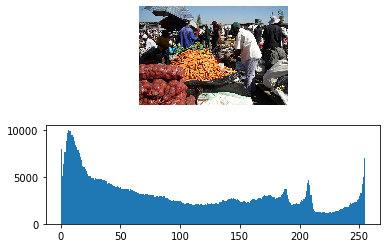

In [8]:
#visualize the first image from the set
I = io.imread(os.path.join(dataDir, train_data_name +r"//" +str(imgIds[0]).zfill(12) + ".jpg"))
#I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)

#Visualize the image
plt.subplot(2,1,1)    
plt.imshow(I)
plt.axis('off')
#visualize the histogram of the image
plt.subplot(2,1,2)   
plt.hist(I.ravel(),256, [0,255]);

In [9]:
# number of classes for prediction based on the to_categorial
num_of_clss = y_train.shape[3]  # number of classes (the number of the categories form the to_categorial by keras)


In [10]:
inp = Input(shape = (x_train.shape[1],x_train.shape[2],x_train.shape[3]))

# First conv block
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(inp)
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Second conv block
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Third conv block
x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(dp)(x)

# forth conv block
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# DECONV AND UNPOOLING

x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

out = Conv2DTranspose(num_of_clss, (3, 3), strides=(1, 1), padding='same', activation = 'softmax')(x)

model = Model(inp,out)


In [11]:
# define the optimizer and compile the model
adam = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:

history = model.fit(x_train, y_train, validation_split=0.3, epochs=epochs, batch_size=bs)


Train on 82800 samples, validate on 35487 samples
Epoch 1/100
82800/82800 [==============================] - 286s 3ms/sample - loss: 0.2632 - accuracy: 0.9096 - val_loss: 0.2333 - val_accuracy: 0.9137loss: 0.4296 - accuracy:  - ETA: 8:00 - loss: 0.4220 - accura - ETA: 7:21 - loss: 0.4090 - accura - ETA: 6:52 - loss: 0.4019 - accuracy - ETA: 6:33 - loss: 0.3926 - accuracy: 0.90 - ETA: 6:29 - loss: 0.390 - ETA: 5:56 - loss: 0.3773 - accura - ETA: 5:43 - loss: 0.3711  - ETA: 5:25 - loss: 0.3616 - ac - ETA: 5:14 - loss: 0.3584  - ETA: 5:02 - loss: 0.3543 - accuracy: 0. - ETA: 5:00 - loss: 0.3533 -  - ETA: 4:51 - loss: 0.3483 -  - ETA: 4:43 - loss: - ETA: 4:33 - loss: 0.3363 - accuracy: 0. - ETA: 4:32 - los - ETA: 4:00 - loss: 0.3176 - accuracy - ETA: 3:58 - l - ETA: 3:52 - loss: 0 - ETA: 3:48 - loss: 0.3110 - accuracy: 0.91 - ETA: 3:47 - loss: 0.3107 - accuracy: 0.91 - ETA: 3:47 - loss: 0.3107 - ac - ETA: 3: - ETA - ETA: 3:20 - ETA: 3:16 - loss: 0.2974 - accuracy: 0.91 - ETA: 3:15 - ETA: 3

82800/82800 [==============================] - 277s 3ms/sample - loss: 0.1982 - accuracy: 0.9232 - val_loss: 0.1950 - val_accuracy: 0.9263oss: 0.2032 - accuracy:  - ETA: 3:27 - loss: 0.2030 - accuracy: 0. - ETA: 3:26 - loss: 0.2028 - accu - ETA: 3:25 - loss: 0.2027 - accuracy - ETA: 3:24 - loss: 0.2027  - ETA: 3:23 - los - E - ETA: 2:46 - loss: 0.2015 - accuracy: 0.92 - ETA: 2:46 - loss: 0.2015 - ac - ETA: 2:45 - loss: 0.2013 -  - ETA: 2:43 - loss: 0.201 - ETA: 2:42 - loss: 0.2011 -  - ETA: 2:36 - loss: 0.2005  - ETA: 2: - ETA:  - ETA: 2:27 - loss: 0.2011 - accuracy: 0. - ETA: 2:27 - loss: 0.2013 - accu - ETA: 2:22 - loss: 0.2013 - accuracy: 0.92 - ETA: 2:22 - loss: 0.2012 - accura - ETA: 2:12 - loss: 0.2009 - accuracy - ETA: 2:11 - loss: 0.2010 - ac - ETA: 2:10 - loss: 0.2012 - accuracy:  - ETA: 2:10 - loss: 0.2012 - accuracy - ETA: 2:09 - loss: 0.2012 - accuracy: 0. - ETA: 2:09 - loss: 0.2012 - accura - ETA: 2:03 - loss: 0.2012 - ac - ETA: 2:02 - loss: 0.2012 - ac - ETA: 2:01 - loss:

KeyboardInterrupt: 

In [ ]:
# plot train and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show(); plt.close()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
#load for validation different directrory different ids
coco_instances = COCO(os.path.join(dataDir,r"annotations\instances_" + val_data_name + ".json"))

# in the .getCatIds(catNms=[list of all ids we want to filter from the data]);
catIds = coco_instances.getCatIds(catNms=categories_names);

# get all the image id for all images here its for the validation
all_imgIds = coco_instances.getImgIds();

# get all the image id for all images based on the filter
imgIds = coco_instances.getImgIds(catIds=catIds);

img_list = []
mask_list = []

for cnt, imgID in enumerate(all_imgIds):
    I = cv2.imread(os.path.join(dataDir, val_data_name +r"//" +str(imgID).zfill(12) + ".jpg"),rgb_on)
    I = cv2.resize(I, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)
    img_list.append(I)
    
    if (imgID in imgIds):
        annIds = coco_instances.getAnnIds(imgIds=imgID, catIds=catIds, iscrowd=None)
        anns = coco_instances.loadAnns(annIds)
        img_data = coco_instances.loadImgs(imgID)[0]
        anns_img = np.zeros((img_height, img_width),)
        for ann in anns:
            mask_res = cv2.resize(coco_instances.annToMask(ann), (img_height, img_width), interpolation = cv2.INTER_AREA )
            anns_img = np.maximum(anns_img, mask_res*(catIds.index((ann['category_id']))+1))
        
        #mask = cv2.resize(anns_img, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)    
        #save mask to disk
        #cv2.imwrite(r"E:\Documents\Study\Deep Learning\Project\TestMASKS\\" +str(imgID).zfill(12) + ".png" , mask)
    else:
        anns_img = np.zeros((img_height, img_width),)
        
    mask_list.append(anns_img)
    
    if (cnt+1 == max_cnt_debug_test):
        break
    
#y_train = read_data(r'E:\Documents\Study\Deep Learning\Project\MASKS')
#y_train = (to_categorical(y_train)).astype('float')

y_test = np.asarray(mask_list)
#y_test = (np.expand_dims(y_test, axis=3)).astype('float')
y_test = (to_categorical(y_test, num_classes=y_train.shape[3], dtype='float32')).astype('float')


x_test = np.asarray(img_list).astype('float')

if (rgb_on == 0):
    x_test = (np.expand_dims(x_test, axis=3)).astype('float')

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


In [ ]:
plt.subplot(3,3,1)
plt.imshow(np.squeeze(x_test[0,:,:].astype('uint8')))
plt.axis('off')

plt.subplot(3,3,2)
plt.imshow(np.squeeze(x_test[1,:,:].astype('uint')))
plt.axis('off')

plt.subplot(3,3,3)
plt.imshow(np.squeeze(x_test[2,:,:].astype('uint')))
plt.axis('off')

In [ ]:
#plt.hist((coco_instances.annToMask(ann)*49).ravel(),256, [0,255]);
#plt.hist(mask_list[0].ravel(),256, [0,255]);
#plt.imshow(mask_list[0])

In [ ]:
# y_pred = loaded_model.predict(x_test)

In [ ]:
y_pred = model.predict(x_test)
test_loss, test_acc = model.evaluate(x_test, y_test)

# Print results
print('test loss:', test_loss)
print('test accuracy:', test_acc)


In [ ]:
# #Visialize the source image
# img = cv2.imread(os.path.join(dataDir, data_name +r"//" +str(imgIds[0]).zfill(12) + ".jpg"),0)
# plt.imshow(img)

In [ ]:
#Visialize the resized image
# visualize the predicted resaults vs the real resaults
img_idx = 0

if (rgb_on == 0):
    plt.imshow((x_test[0,:,:,0]).astype('uint8'))
else:
    plt.imshow((x_test[0,:,:]).astype('uint8'))
plt.axis('off')

In [ ]:
# visualize the predicted resaults vs the real resaults
img_idx = 0

plt.subplot(3,2,1)
plt.imshow((y_pred[img_idx,:,:,0]*255).astype('uint8'))
plt.axis('off')

plt.subplot(3,2,2)
plt.imshow((y_pred[img_idx,:,:,1]*255).astype('uint8'))
plt.axis('off')

plt.subplot(3,2,3)
plt.imshow((y_test[img_idx,:,:,0]*255).astype('uint8'))
plt.axis('off')

plt.subplot(3,2,4)
plt.imshow((y_test[img_idx,:,:,1]*255).astype('uint8'))
plt.axis('off')
